## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from numba import njit
from scipy.linalg import eig

## Helper

In [5]:
def get_paper_strategies():
    """
    Generates the full strategy space for 10-bit strategies.
    Format: [Env1 (probs for 0..4 cooperators), Env2 (probs for 0..4 cooperators)]
    Bits represent deterministic moves (0=D, 1=C) based on local group cooperation levels.
    """
    num_bits = 10
    num_strats = 2**num_bits
    indices = np.arange(num_strats)
    # Vectorized bit extraction to create the strategy matrix
    strategies = ((indices[:, None] & (1 << np.arange(num_bits)[::-1])) > 0).astype(np.int64)
    return strategies

def calc_binom_matrix(N, n):
    """
    Pre-calculates the hypergeometric probability matrix.
    bm[M, k] is the probability that a group of size n chosen from population N
    contains exactly k mutants, given there are M mutants in the total population.
    """
    bm = np.zeros((N, n + 1))
    for M in range(N):
        for k in range(n + 1):
            total_ways = comb(N - 1, n - 1)
            if total_ways > 0:
                # Sampling logic: selecting k from M mutants and (n-1-k) from (N-1-M) residents
                # (One slot is fixed for the focal player)
                bm[M, k] = (comb(M, k) * comb(N - 1 - M, n - 1 - k)) / total_ways
    return bm

## Numba Accelerated Core

In [6]:
@njit(fastmath=True)
def solve_stationary(M):
    """
    Solves M.T * v = v for the stationary distribution v.
    """
    dim = M.shape[0]
    A = M.T - np.eye(dim)
    A[-1] = np.ones(dim)  # Replace last equation with normalization constraint
    b = np.zeros(dim)
    b[-1] = 1.0
    try:
        v = np.linalg.solve(A, b)
    except:
        # Fallback for singular matrices
        v = np.ones(dim) / dim
    return v / np.sum(v)

@njit(fastmath=True)
def calc_pay_numba(strategies, k_threshold, r1, r2, c, epsilon):
    """
    Calculates average payoffs and time in State 1 for a specific group composition.
    Uses a Markov chain where states encode [Current Environment + Actions].
    """
    n = strategies.shape[0]
    # State space size: 2^(n+1) -> 1 bit for Env, n bits for previous actions
    num_states = 1 << (n + 1)
    
    # Apply implementation error (noise)
    str_prob = (1 - epsilon) * strategies + epsilon * (1 - strategies)

    M = np.zeros((num_states, num_states))
    pi_round = np.zeros((num_states, n))

    for row in range(num_states):
        # Extract Current Environment (Highest bit)
        current_env = (row >> n) & 1 
        
        # Parse current round actions from the state bits
        actions = np.zeros(n, dtype=np.int64)
        nr_coop = 0
        for i in range(n):
            act = (row >> (n - 1 - i)) & 1
            actions[i] = act
            nr_coop += act

        # 1. Calculate payoffs for this state
        mult = r1 if current_env == 0 else r2
        for j in range(n):
            pi_round[row, j] = (nr_coop * mult * c / n) - (actions[j] * c)

        # 2. Determine Next Environment based on threshold k
        # If cooperators >= k, go to Env 0 (Good), else Env 1 (Bad)
        next_env_val = 0 if nr_coop >= k_threshold else 1

        for next_row in range(num_states):
            # The destination state must match the calculated next environment
            if ((next_row >> n) & 1) == next_env_val:
                p_trans = 1.0
                for i in range(n):
                    # Determine probability of choosing C based on strategy and current state
                    # Strategies are indexed by [Env * 5 + Num_Cooperators]
                    s_idx = current_env * 5 + nr_coop
                    p_c = str_prob[i, s_idx]
                    
                    next_act = (next_row >> (n - 1 - i)) & 1
                    p_trans *= p_c if next_act == 1 else (1.0 - p_c)
                M[row, next_row] = p_trans

    v = solve_stationary(M)
    
    # Aggregate results
    pivec = np.zeros(n)
    avg_c = 0.0
    time_s1 = 0.0
    
    for s in range(num_states):
        for j in range(n): 
            pivec[j] += v[s] * pi_round[s, j]
        
        # Calculate cooperation rate in this state
        c_count = 0
        for b in range(n):
            if (s >> (n - 1 - b)) & 1: c_count += 1
        avg_c += v[s] * (c_count / n)
        
        # Check if state represents Environment 1 (Good)
        if (s >> n) & 1 == 0: 
            time_s1 += v[s]
            
    return pivec, avg_c, time_s1



@njit(fastmath=True)
def calc_rho(s1_idx, s2_idx, pay_pure, N, n, k_val, r1, r2, c, beta, bm, all_strats, eps):
    """
    Calculates the fixation probability (Rho) of a mutant (s1) invading a resident (s2).
    Uses the analytical solution for the Moran process with pairwise comparison.
    """
    # pay matrix: [Number of mutants in group, 0=Mutant Payoff / 1=Resident Payoff]
    pay = np.zeros((n + 1, 2))
    pay[n, 0] = pay_pure[s1_idx] # All mutants
    pay[0, 1] = pay_pure[s2_idx] # All residents

    # Calculate payoffs for mixed groups (1 to n-1 mutants)
    for n_mut in range(1, n):
        group = np.zeros((n, 10), dtype=np.int64)
        for i in range(n_mut): group[i] = all_strats[s1_idx]
        for i in range(n_mut, n): group[i] = all_strats[s2_idx]
        
        pi_vec, _, _ = calc_pay_numba(group, k_val, r1, r2, c, eps)
        pay[n_mut, 0] = pi_vec[0]      # Average payoff of mutant
        pay[n_mut, 1] = pi_vec[n_mut]  # Average payoff of resident

    # --- Core Moran Process Calculation ---
    # S_i = sum_{j=1}^i beta * (Payoff_Resident - Payoff_Mutant)
    # Rho = 1 / (1 + sum(exp(S_i)))
    S = np.zeros(N)
    cumulative_diff = 0.0
    for i in range(1, N):
        f_i = 0.0 # Expected payoff of Mutant when population has i mutants
        g_i = 0.0 # Expected payoff of Resident when population has i mutants
        
        # Average over all possible group compositions using hypergeometric probs (bm)
        for k_nb in range(n):
            f_i += bm[i-1, k_nb] * pay[k_nb+1, 0]
            g_i += bm[i, k_nb] * pay[k_nb, 1]
        
        cumulative_diff += beta * (g_i - f_i)
        S[i] = cumulative_diff

    # Numerical stability: shift exponents to avoid overflow
    max_S = np.max(S)
    sum_exp = np.sum(np.exp(S - max_S))
    return (1.0 / sum_exp) * np.exp(-max_S)


## Main

In [7]:
def run_final_simulation():
    # Simulation Parameters
    N, n, beta = 100, 4, 1.0 
    r1, r2, c = 2.0, 0.5, 1.0 
    eps = 0.0001

    # Strategy Sampling
    all_strats_full = get_paper_strategies()
    
    # Inject specific key strategies to ensure analysis covers known behaviors
    key_strategies = [
        [0]*10,                       # AllD
        [1]*10,                       # AllC
        [1,1,1,1,1, 0,0,0,0,1],       # Case E Repairer (Needs 4C to restore S1)
        [1,1,1,1,1, 0,0,0,0,0]        # Grim Trigger / Avenger
    ]
    
    # Randomly sample additional strategies to reach a subset size (e.g., 200 + 4)
    indices = np.random.choice(1024, 200, replace=False)
    combined = [np.array(s) for s in key_strategies] + [all_strats_full[i] for i in indices]
    all_strats = np.array(combined)
    num_s = len(all_strats)
    
    bm = calc_binom_matrix(N, n)
    ks = [0, 1, 2, 3, 4, 5] # Threshold values to test
    
    final_coop, final_s1 = [], []

    for k_val in ks:
        # 1. Pre-calculate pure strategy payoffs (homogeneous populations)
        pay_pure, coop_pure, time_pure = np.zeros(num_s), np.zeros(num_s), np.zeros(num_s)
        for i in range(num_s):
            group = np.repeat(all_strats[i:i+1], n, axis=0)
            pi, ac, ts1 = calc_pay_numba(group, k_val, r1, r2, c, eps)
            pay_pure[i], coop_pure[i], time_pure[i] = pi[0], ac, ts1

        # 2. Build Mutation-Selection Transition Matrix
        trans_M = np.zeros((num_s, num_s))
        for j in range(num_s): # Resident
            for i in range(num_s): # Mutant
                if i != j:
                    rho = calc_rho(i, j, pay_pure, N, n, k_val, r1, r2, c, beta, bm, all_strats, eps)
                    trans_M[j, i] = rho / (num_s - 1)
            # Diagonal: Probability of staying (no fixation of any mutant)
            trans_M[j, j] = 1.0 - np.sum(trans_M[j, :])

        # 3. Calculate global stationary distribution
        vals, vecs = eig(trans_M.T)
        stat = vecs[:, np.argmin(np.abs(vals - 1.0))].real
        stat /= np.sum(stat)

        # 4. Weighted Averages
        final_coop.append(np.dot(stat, coop_pure))
        final_s1.append(np.dot(stat, time_pure))
        print(f"Completed k={k_val}, Avg Cooperation: {final_coop[-1]:.4f}")

    # Plotting Results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.bar(ks, final_s1, edgecolor='black')
    ax1.set_title('Time in Beneficial State 1 (h)')
    ax1.set_xlabel('Threshold k')
    ax1.set_ylim(0, 1.05)
    
    ax2.bar(ks, final_coop, edgecolor='black')
    ax2.set_title('Average Cooperation Rate (g)')
    ax2.set_xlabel('Threshold k')
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()

Completed k=0, Avg Cooperation: 0.3863
Completed k=1, Avg Cooperation: 0.8361
Completed k=2, Avg Cooperation: 0.8881
Completed k=3, Avg Cooperation: 0.9625
Completed k=4, Avg Cooperation: 0.8775
Completed k=5, Avg Cooperation: 0.0033


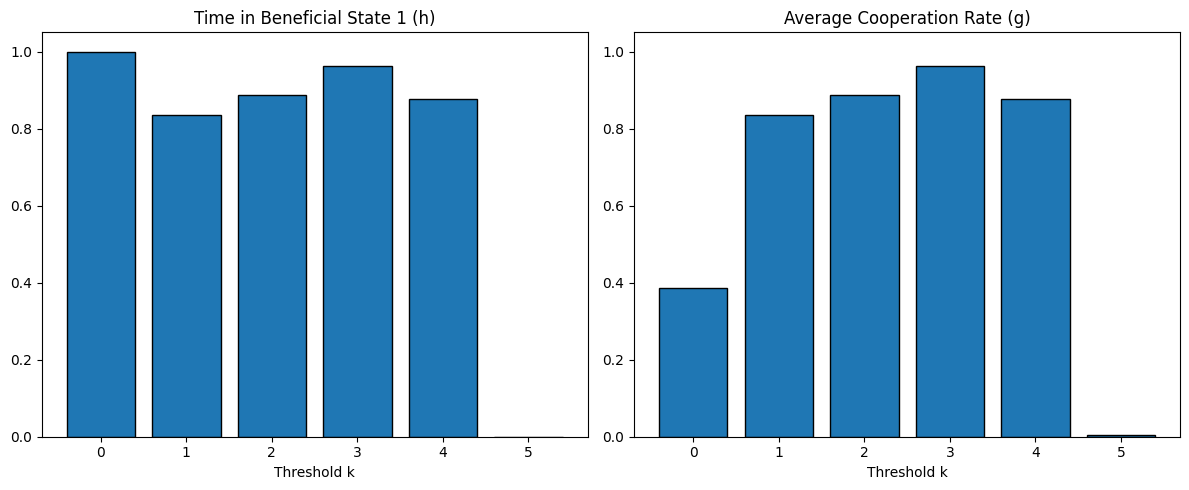

In [8]:
run_final_simulation()